In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 15) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 15) # fontsize of the tick labels
plt.rc("ytick", labelsize = 15) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

In [3]:
# Load corresponding best files for each country.
countries = [("Yemen", 3), ("Syria", 3), ("Burkina Faso", 3), ("Nigeria", 4), ("Mali", 4), ("Cameroon", 2)] 

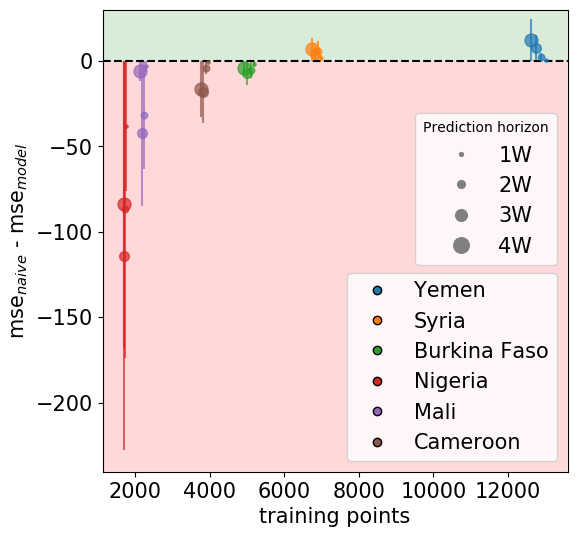

In [4]:
fig, axs = plt.subplots(figsize = (6, 6))

for i,country in enumerate(countries):
    # Load training shapes.
    training_shape = pd.read_csv(f"./{country[0]}/out_hyper_{country[1]}/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
    # Load mse loss based on prediction horizons.
    loss_h = pd.read_csv(f"./{country[0]}/out_hyper_{country[1]}/loss_h.csv", index_col = [0, 1], header = [0, 1]).droplevel(0, axis = 0)
    
    # Concatenate loss and training shape information.
    results = loss_h.stack(["Split"])
    # For each split get difference between 'mse_naive' and 'mse_model'.
    results["diff"] =  results["mse_naive"] - results["mse_model"]
    results = results.unstack().reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    results_std = results.groupby(axis = 1, level = 1).std()
    # Select some prediction horizon.
    results_mean = results_mean.loc[[7,14,21,28]]
    results_std = results_std.loc[[7,14,21,28]]

    for j in range(len(results_mean)):
        axs.errorbar(results_mean.iloc[j]["training points"], results_mean.iloc[j]["diff"],
                     yerr = results_mean.iloc[j]["diff"], marker = "o", linestyle = "none", 
                     color = sns.color_palette("tab10")[i], markersize = results_mean.index[j]/3, alpha=0.7)

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")
 
# Legend.
h = [plt.plot([],[], color = sns.color_palette("tab10")[i], marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i,country in enumerate(countries)]
h = plt.legend(handles = h, labels = [country[0] for country in countries], loc = "lower right")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"], loc = "upper right", bbox_to_anchor=(1,0.8), title="Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel("mse$_{naive}$ - mse$_{model}$")

a = (axs.get_xlim()[0], axs.get_xlim()[1])
b = (axs.get_ylim()[0], 50)

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor = "green", alpha = 0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0], facecolor = "red", alpha = 0.15)

axs.set_xlim(a)
axs.set_ylim((b[0], 30))

fig.savefig("image_comparison.png" , bbox_inches = "tight", dpi = 600)